# 1. Data Exploration
First, we explore the dataset and perform some descriptive analysis

## Import necessary packages

In [7]:
# Install necessary packages, if not present
# !pip install tensorflow
# !pip install sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats 
import datetime as dt
import datetime
import time

# % matplotlib inline

# feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import cross_validate
from sklearn import linear_model

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

## Read CSV File

In [8]:
df = pd.read_csv('data/loan.csv',low_memory=True)
df.head()

/Users/chihongtao/anaconda/envs/notebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Check column info and NULL values

In [9]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 145 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          0 non-null        float64
 1   member_id                                   0 non-null        float64
 2   loan_amnt                                   2260668 non-null  int64  
 3   funded_amnt                                 2260668 non-null  int64  
 4   funded_amnt_inv                             2260668 non-null  float64
 5   term                                        2260668 non-null  object 
 6   int_rate                                    2260668 non-null  float64
 7   installment                                 2260668 non-null  float64
 8   grade                                       2260668 non-null  object 
 9   sub_grade                                   2260668 non-

## Distribution of loan amount, term, year

<ipython-input-10-2fb512dd40ec>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


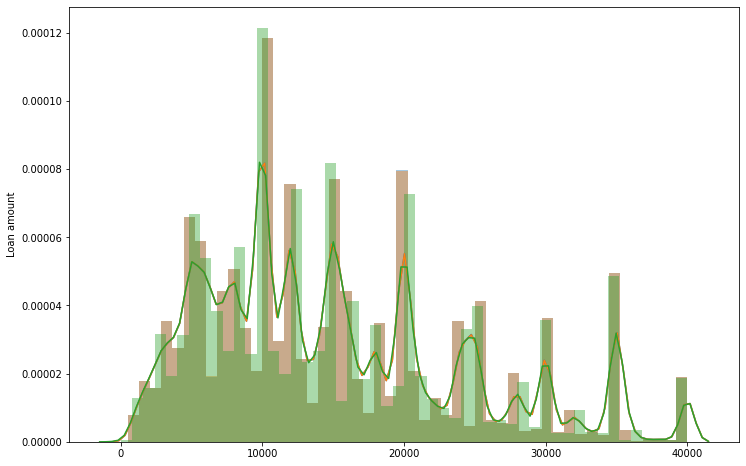

In [10]:
plt.figure(figsize=(12,8))
# Plot the distribution of loan amount applied by borrower
sns.distplot(df['loan_amnt'])
# Plot the distribution loan amount committeed
sns.distplot(df['funded_amnt'])
# Plot the distribution of loan amount committed by investors
sns.distplot(df['funded_amnt_inv'])
plt.ylabel('Loan amount')
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)

 36 months    0.71207
 60 months    0.28793
Name: term, dtype: float64


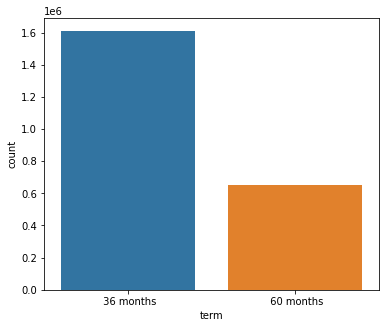

In [11]:
# Plot the term of the loans applied, in terms of percentage over all loans
print (df['term'].value_counts(normalize=True))
plt.figure(figsize=(6,5))
sns.countplot(df['term'])

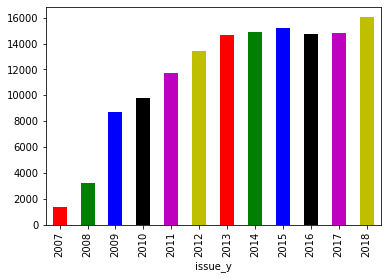

In [12]:
# Extract the year & month from issue_d and plot the average loan amount with respect to year
df['issue_y'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.year)
df['issue_m'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.month)
# Plot the funded loan amount by year
df.groupby('issue_y')['funded_amnt_inv'].mean().plot(kind='bar',color=['r', 'g', 'b', 'k', 'm', 'y'])
# sns.lineplot(df.groupby('issue_y')['funded_amnt_inv'].mean().index, df.groupby('issue_y')['funded_amnt_inv'].mean().values)

### Observation
* Loan amount applied follows a multi-nomial distribution, mostly falling within 10k - 20k range
* Loan amount applied, funded and funded_invested follows similar distributions, this means most loans applied by eligible borrowers are approved and funded by investors
* _71%_ of the loans applied are for _36_ months, while _29%_ are for _60_ months.
* Average loan amount increases each year, with significant jump in _2009, peak around 2015-2018_. This is probably due to financial crisis in _2008_ , which resulted in low interest rate between _2009-2018_

## Good Loan v.s. Bad Loan

* We categorise the loan as a bad loan if the loan status is any of these: _["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]_
* Also, there is a significant number of loans that are under the status of __"Current"__, which we cannot tell whether it is a good / bad loan at the moment. Hence, we need to __remove such loans__ from the dataset before splitting into training/test dataset.
* With this categorisation, we can see _22%_ of the loans are bad loans. Hence, this is an __imbalanced dataset__, with large number of negatives if we are predicting bad loans
* However, we have to keep in mind that some of the "bad" loans might still be paid later, especially loans that are more recent in this time horizon. Hence, for the higher percentage of bad loans from _2016-2018_, their status might be temporary and not conclusive

In [13]:
# Inspect loan status
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

[Text(0, 0.5, '(%)')]

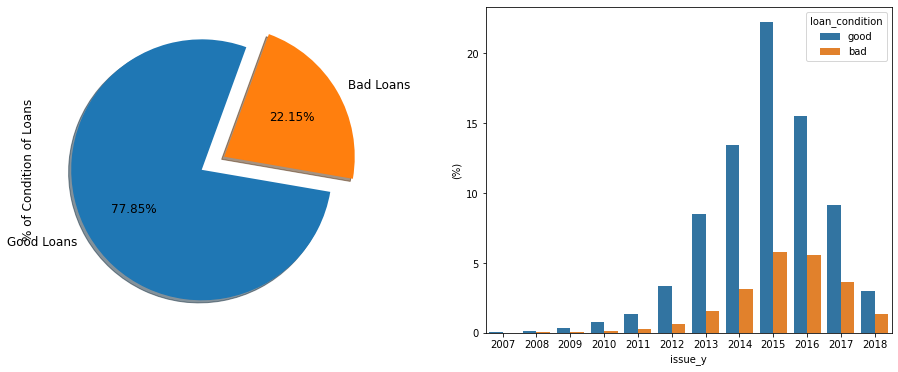

In [14]:
# Remove loans under "Current" status
df = df[df['loan_status']!='Current']

# We can categorise the loan as good / bad loan. 
# From the pie chart, 22% of the loans are bad loans
f, ax = plt.subplots(1,2, figsize=(16,6))
labels ="Good Loans", "Bad Loans"
bad_loan_statuses = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", \
                     "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
df['loan_condition'] = df['loan_status'].apply(lambda x: 'bad' if x in bad_loan_statuses else 'good')
df['loan_condition'].value_counts().plot(kind='pie', explode=[0,0.2], autopct='%1.2f%%',\
                                         ax=ax[0], labels=labels, fontsize=12, startangle=70, shadow=True)
ax[0].set_ylabel('% of Condition of Loans', fontsize=12)

sns.barplot(x="issue_y", y="loan_amnt", hue="loan_condition", data=df,\
            estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

## Plotting loans for each state

We can see that Lending clubs borrowers are most active in the few states where economy is doing well, e.g. California, Texas, New York, Florida, Illinois etc. While the states with lowest amount of loans are mostly in the Mid-West, such as North Dakota, Idaho, South Dakota etc. 

Text(0.5, 0, 'State')

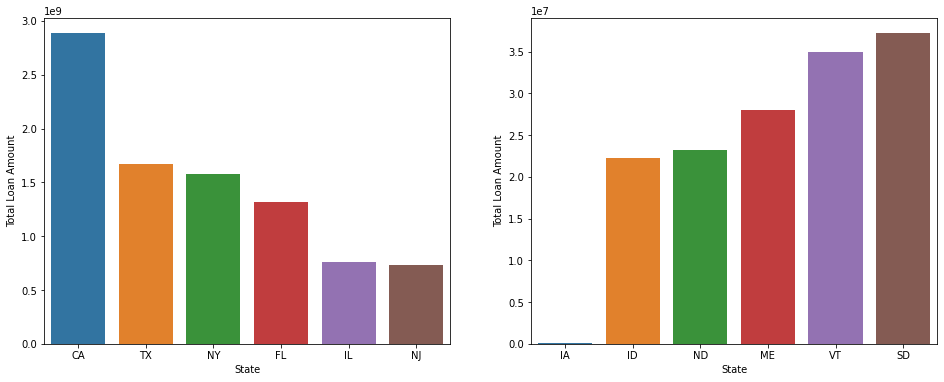

In [15]:
# Examine which state has the highest & lowest amount of loan in total
group_date = df.groupby(['addr_state'],as_index=False)['loan_amnt'].sum()
top_6_states = group_date.sort_values('loan_amnt',ascending=False).iloc[0:6]
btm_6_states = group_date.sort_values('loan_amnt').iloc[0:6]
fig, axs = plt.subplots(1,2, figsize=(16,6))
sns.barplot(x='addr_state', y='loan_amnt',data=top_6_states, ax=axs[0])
sns.barplot(x='addr_state', y='loan_amnt',data=btm_6_states, ax=axs[1])
axs[0].set_ylabel("Total Loan Amount")
axs[0].set_xlabel("State")
axs[1].set_ylabel("Total Loan Amount")
axs[1].set_xlabel("State")

### Observation
By plotting the loan condition splits for the top 6 & bottomr 6 states, we can see that states differ in the percentage of bad loans. 
* For the top 6 states in terms of loan amount, most of them have close to the overall average (~22%) of bad loans, while New York, Florida, New Jersey have slightly more than average bad loan percentage.
* While for the bottom 6 states, two of the states (Maine, Vermont) have far less percentage of bad loans than average. This could be due to these states being more financially conservative. 
* This means that state has a bearing on the percentage of good v.s. bad loans somehow

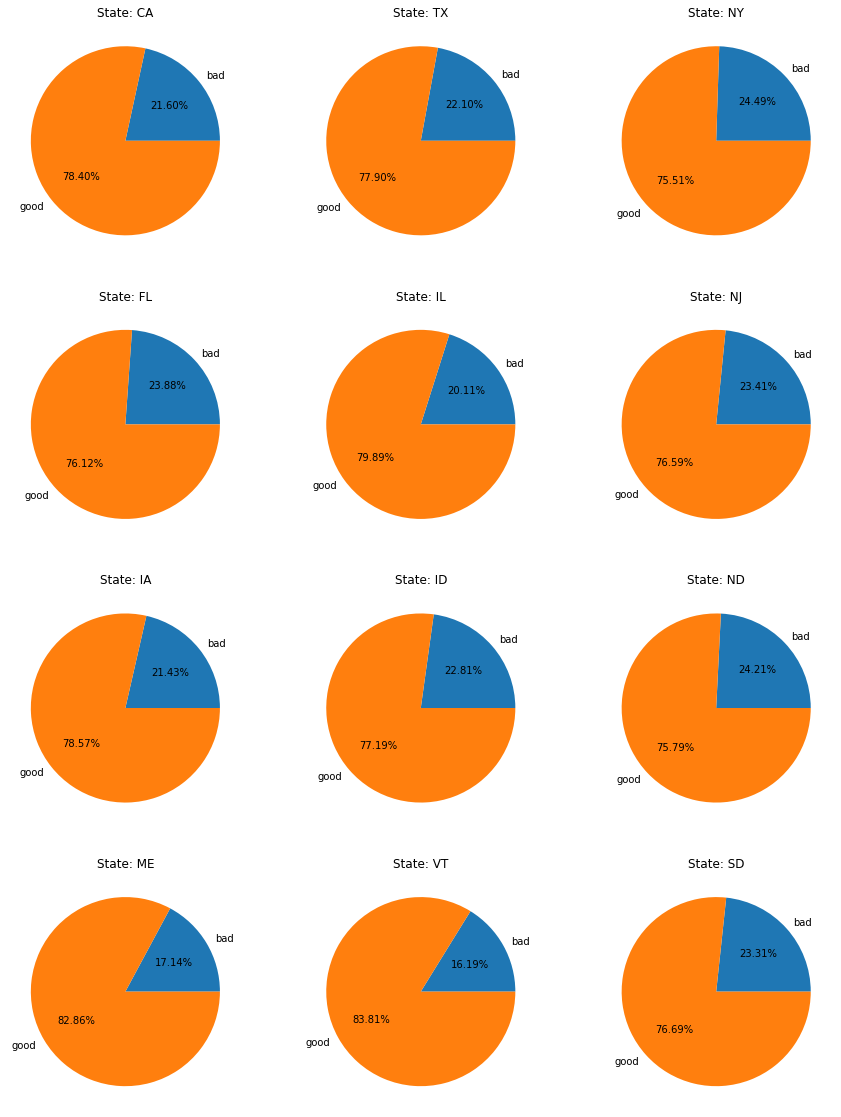

In [16]:
top_6_ls = list(top_6_states['addr_state'])
btm_6_ls = list(btm_6_states['addr_state'])
state_loan_condition = df.groupby('addr_state')['loan_condition'].value_counts(normalize=True).\
              unstack().reset_index().rename_axis(None, axis=1).set_index('addr_state')
plot_df = pd.concat([state_loan_condition.loc[top_6_ls], state_loan_condition.loc[btm_6_ls]])
# plot_df = state_loan_condition[~state_loan_condition.index.isin(['IA'])]
# print (plot_df.count())
# plot the pie good & bad loan percentage for the top 6 & bottom 6 states
fig = plt.figure(figsize=(15,20))
# print (state_loan_condition.count())
for i, (name, row) in enumerate(plot_df.iterrows()):
    ax = plt.subplot(4,3, i+1)
    ax.set_title("State: %s"%row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index, autopct='%1.2f%%')

## Loan metrics by region
Furthermore, we decided to break down the country into four regions based on geography and plot some of the descriptive metrics for each region.

Text(0.5, 0, 'Year')

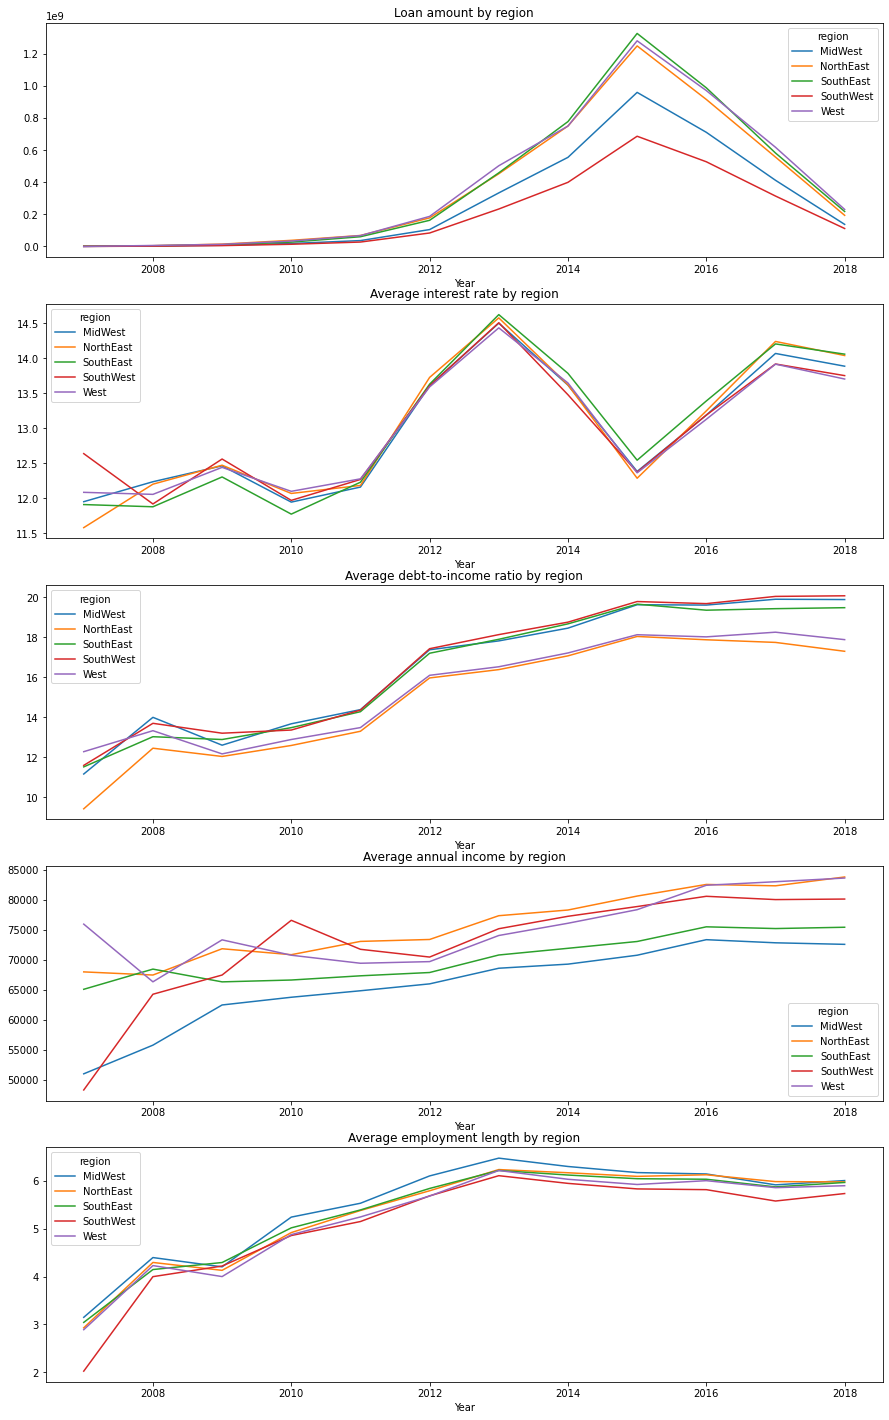

In [17]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

df['region'] = df['addr_state'].apply(finding_regions)
    
df['emp_length_int'] = np.nan

def update_emp_length_int(emp_length):
    emp_length_int = None
    if emp_length == '10+ years':
        emp_length_int = 10
    elif emp_length == '9 years':
        emp_length_int = 9
    elif emp_length == '8 years':
        emp_length_int = 8
    elif emp_length == '7 years':
        emp_length_int = 7
    elif emp_length == '6 years':
        emp_length_int = 6
    elif emp_length == '5 years': 
        emp_length_int = 5
    elif emp_length == '4 years':
        emp_length_int = 4
    elif emp_length == '3 years':
        emp_length_int = 3
    elif emp_length == '2 years': 
        emp_length_int = 2
    elif emp_length == '1 year':
        emp_length_int = 1
    elif emp_length == '< 1 year':
        emp_length_int = 0.5
    elif emp_length == 'n/a':
        emp_length_int = 0    
    return emp_length_int

df['emp_length_int'] = df['emp_length'].apply(update_emp_length_int)

# plt.style.use('dark_background')
f, ax = plt.subplots(5,1, figsize=(15,25))

grouped_df = df.groupby(['issue_y','region'])

loan_by_region = grouped_df.loan_amnt.sum()
# loan_by_region_date.head()
loan_by_region.unstack().plot(ax=ax[0], stacked=False)
ax[0].set_title('Loan amount by region')
ax[0].set_xlabel('Year')

int_rate_by_region = grouped_df.int_rate.mean()
int_rate_by_region.unstack().plot(ax=ax[1])
ax[1].set_title('Average interest rate by region')
ax[1].set_xlabel('Year')

dti_by_region = grouped_df.dti.mean()
dti_by_region.unstack().plot(ax=ax[2])
ax[2].set_title('Average debt-to-income ratio by region')
ax[2].set_xlabel('Year')

income_by_region = grouped_df.annual_inc.mean()
income_by_region.unstack().plot(ax=ax[3])
ax[3].set_title('Average annual income by region')
ax[3].set_xlabel('Year')

emp_length_by_region = grouped_df.emp_length_int.mean()
emp_length_by_region.unstack().plot(ax=ax[4])
ax[4].set_title('Average employment length by region')
ax[4].set_xlabel('Year')

### Observation
* SouthEast, West, NorthEast have the highest total loans amounts for most of the years, while SouthWest has the lowest 
* This also corresponds to the average interest rate per year, where SouthEast & NorthEast are the highest in most years. This means loans in SouthEast & NorthEast tend to give higher returns to investors
* Despite the low total loan amounts, SouthWest has the highest debt to income ratio. While NorthEast & West have rather low debt-to-income ratio
* NorthEast & West have the highest average annual income, which might explain their low debt-to-income ratio
* MidWest has the highest average employment length in most years, but annual income are the lowest 

## Loan condition by region
Here, we plot the loan condition - good / bad, for each region, similar to how we plotted by states

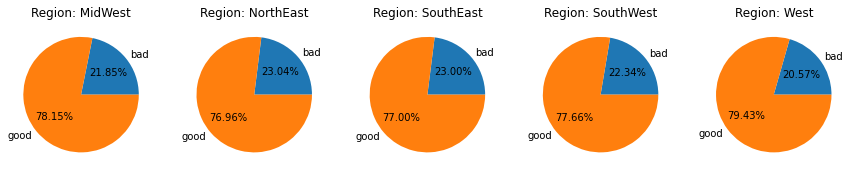

In [18]:
reg_loan_condition = df.groupby('region')['loan_condition'].value_counts(normalize=True).\
              unstack().reset_index().rename_axis(None, axis=1).set_index('region')
# plot the pie good & bad loan percentage for each region
fig = plt.figure(figsize=(15,20))
# print (state_loan_condition.count())
for i, (name, row) in enumerate(reg_loan_condition.iterrows()):
    ax = plt.subplot(1,5, i+1)
    ax.set_title("Region: %s"%row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index, autopct='%1.2f%%')

Let's have a closer look at breakdown of __bad loans__ for each region. We can see that for each state, majority of the bad loans are charged off. During the modelling section, we will see if __region__ field has any impact to the classification of good / bad loans

<Figure size 1080x2160 with 0 Axes>

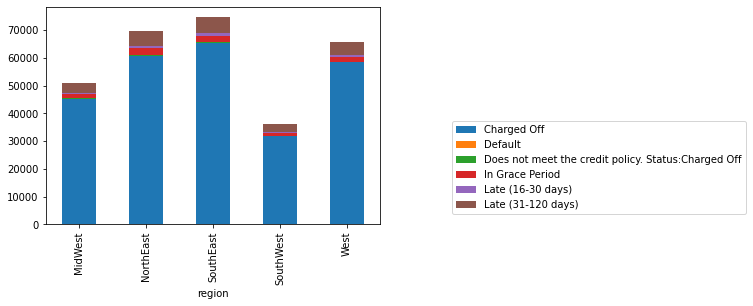

In [19]:
bad_loan_df = df[df['loan_condition']=='bad']
# print (pd.crosstab(bad_loan_df['region'], bad_loan_df['loan_status']))
fig = plt.figure(figsize=(15,30))
bad_loan_df.groupby(['region','loan_status'])['loan_amnt'].count().unstack().plot(kind='bar',stacked=True).legend(bbox_to_anchor=(1.2, 0.5))